In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
!pip install wget
import wget

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [55]:
path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
path1 = '../input/imdb-dataset/Test.csv'
df = pd.read_csv(path)
df1= pd.read_csv(path1)
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [56]:
print(df.shape)

(50000, 2)


### Splitting to train and test data

In [57]:
X,y = df['review'].values,df['sentiment'].values
#stratify=y
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (40000,)
shape of test data is (10000,)


### EDA

In [58]:
def preprocess_string(review):
    """
    we tried to run the model with/without the removing of the html tags and urls. 
    the accruacy without removing them was better.with removing them the val_accrucay was 50%. 
    
    #Removing HTML tag from review
    
    clean = re.compile('<.*?>')
    review_without_tag = re.sub(clean, '', review) 
    
    
   
    #Removing URLs
    
    review_without_tag_and_url = re.sub(r"http\S+", "", review_without_tag)
    
    review_without_tag_and_url = re.sub(r"www\S+", "", review_without_tag)
    """   
    # Remove all non-word characters (everything except numbers and letters)
    review = re.sub(r"[^\w\s]", '', review)
    # Replace all runs of whitespaces with no space
    review = re.sub(r"\s+", '', review)
    # replace digits with no space
    review = re.sub(r"\d", '', review)
    return review

def clean_text(review):
    lowercase = review.lower().replace('\n', ' ')
    stripped_html = re.sub('<br />', ' ', lowercase)
    cleaned_punctuation = re.sub('[%s]'%re.escape(string.punctuation), '', stripped_html)
    return cleaned_punctuation


In [59]:
MAX_WORDS = 10000   
MAX_LEN = 200
word_count_dict = {}

for review in df['review'].values:
    cleaned_text = clean_text(review)
    for word in cleaned_text.split(' '):
        word_count_dict[word] = word_count_dict.get(word, 0) + 1
            
df_word_dict = pd.DataFrame(pd.Series(word_count_dict, name='count'))
df_word_dict = df_word_dict.sort_values(by='count', ascending=False)

df_word_dict = df_word_dict[:MAX_WORDS-2]     # 总共取前max_words-2个词
df_word_dict['word_id'] = range(2, MAX_WORDS)

word_id_dict = df_word_dict['word_id'].to_dict()

word_id_dict['<unknown>'] = 0
word_id_dict['<padding>'] = 1

df_word_dict.head(10)

,count,word_id
the,663859,2
and,320677,3
a,320565,4
of,288476,5
to,266925,6
is,210505,7
in,185054,8
,158328,9
it,154880,10
i,152104,11


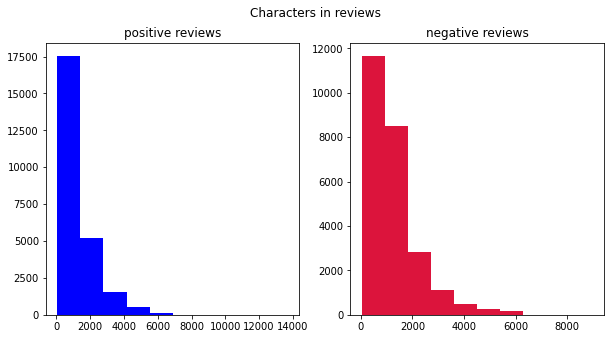

In [60]:
#Number of characters in reviews

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
review_len=df[df['sentiment']=="positive"]['review'].str.len()
ax1.hist(review_len,color='blue')
ax1.set_title('positive reviews')
review_len=df[df['sentiment']=="negative"]['review'].str.len()
ax2.hist(review_len,color='CRIMSON')
ax2.set_title('negative reviews')
fig.suptitle('Characters in reviews')
plt.show()

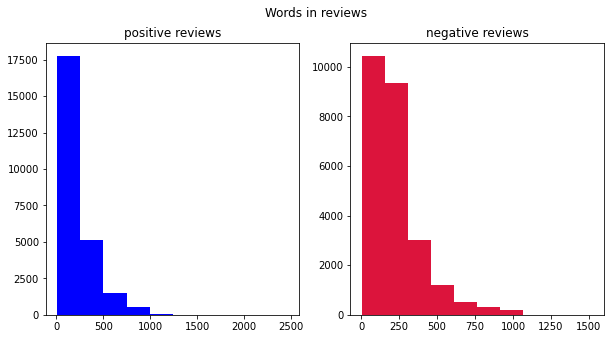

In [61]:
#Number of words in reviews
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
review_len=df[df['sentiment']=="positive"]['review'].str.split().map(lambda x: len(x))
ax1.hist(review_len,color='blue')
ax1.set_title('positive reviews')
review_len=df[df['sentiment']=="negative"]['review'].str.split().map(lambda x: len(x))
ax2.hist(review_len,color='CRIMSON')
ax2.set_title('negative reviews')
fig.suptitle('Words in reviews')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each review')

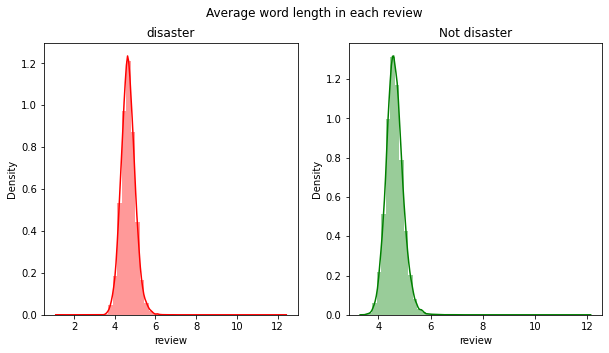

In [62]:
#Average word length in a review
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['sentiment']=="positive"]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=df[df['sentiment']=="negative"]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each review')

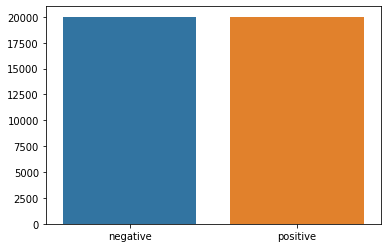

In [63]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tockenization

In [64]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

*we can use this line of code in the cnn part !

In [65]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [66]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

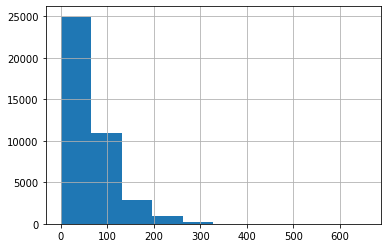

count    40000.000000
mean        69.197950
std         48.062704
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        655.000000
dtype: float64

In [67]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

# LSTM PART

### Padding

Padding each of the sequence to max length.

In [68]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [69]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

### Batching and loading as tensor

In [70]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [71]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   4,  88, 802],
        [  0,   0,   0,  ...,  71, 199, 700],
        [  0,   0,   0,  ..., 774, 131, 318],
        ...,
        [  0,   0,   0,  ..., 933,  82, 263],
        [  0,   0,   0,  ...,  19,  19,  65],
        [  0,   0,   0,  ..., 108, 115,   2]])
Sample input: 
 tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0])


### Model

In [72]:
class Main_LSTM(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(Main_LSTM,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [73]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = Main_LSTM(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

Main_LSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [74]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [75]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.5157631497085094 val_loss : 0.42126626886427404
train_accuracy : 74.8075 val_accuracy : 81.6
Validation loss decreased (inf --> 0.421266).  Saving model ...
Epoch 2
train_loss : 0.3849403678998351 val_loss : 0.4182338270545006
train_accuracy : 83.5475 val_accuracy : 82.14
Validation loss decreased (0.421266 --> 0.418234).  Saving model ...
Epoch 3
train_loss : 0.33536953549832105 val_loss : 0.3431692895293236
train_accuracy : 85.785 val_accuracy : 84.71
Validation loss decreased (0.418234 --> 0.343169).  Saving model ...
Epoch 4
train_loss : 0.304090596139431 val_loss : 0.3541413947194815
train_accuracy : 87.055 val_accuracy : 85.21
Epoch 5
train_loss : 0.2796643843129277 val_loss : 0.34099653460085394
train_accuracy : 88.40249999999999 val_accuracy : 85.59
Validation loss decreased (0.343169 --> 0.340997).  Saving model ...


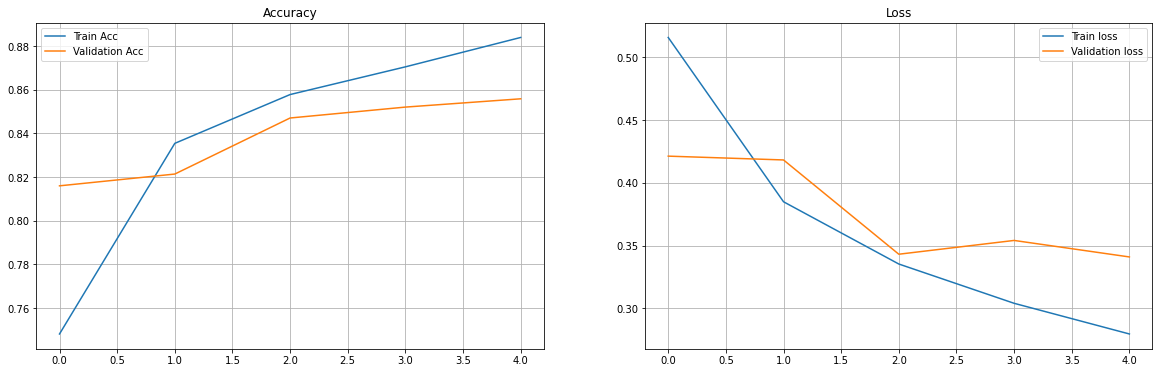

In [76]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.8737    0.8331    0.8529      5015
           0     0.8396    0.8788    0.8588      4985

    accuracy                         0.8559     10000
   macro avg     0.8566    0.8560    0.8558     10000
weighted avg     0.8567    0.8559    0.8558     10000



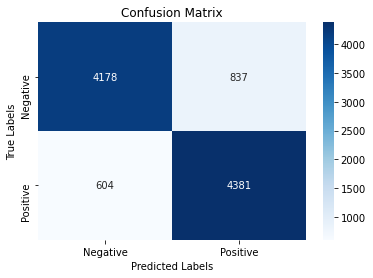

In [77]:
# Evaluation Function
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
def evaluate(model,valid_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    val_h = model.init_hidden(batch_size)
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader :
            
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    
    
evaluate(model, valid_loader)

AUC ROC :
0.8559686037174334
----------------------------------------------------------


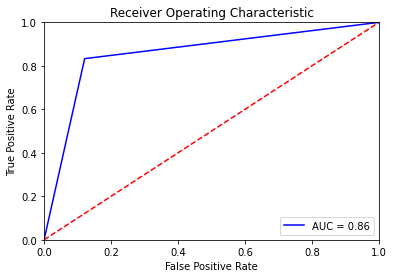

In [78]:
def plot_auc_roc(model,valid_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    val_h = model.init_hidden(batch_size)
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader :
            
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('AUC ROC :')
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    

    #roc_auc = roc_auc_score(y_true, y_pred)
    print(roc_auc)
    print('----------------------------------------------------------')
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

plot_auc_roc(model, valid_loader) 

# Predicting the unlabeled datset

In [79]:
outputs = list()
status = list()
for review in df1['Review'][:] :
    #print(text)
    word_seq = np.array([vocab[preprocess_string(word)] for word in review.split() 
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,500))
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    #print(output.item())
    pro = output.item()
    outputs.append(pro)


df1['outputs'] = outputs

In [80]:
df1['outputs'] = df1['outputs'].astype(float)  
predicted_sentiment = list()
df1.head(10)
for i in df1['outputs'][:] : 
    if i < 0.5 : 
        predicted_sentiment.append('Negative') 
    else : 
        predicted_sentiment.append('Positive')

df1['predicted_sentiment'] = predicted_sentiment    
        
        
print(df1.shape)
print(df1['predicted_sentiment'].value_counts())

(2000, 4)
Negative    1036
Positive     964
Name: predicted_sentiment, dtype: int64


In [81]:
df1_pos = df1[df1['predicted_sentiment']=='Positive']
df1_neg = df1[df1['predicted_sentiment']=='Negative']
print(df1_pos.shape)
print(df1_neg.shape)

(964, 4)
(1036, 4)


# Wordclouds for predicted reviews

In [82]:
import pandas as pd
import numpy as np

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from matplotlib.pyplot import figure

In [83]:
STOPWORDS.add('https')  # remove htps to the world Cloud

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

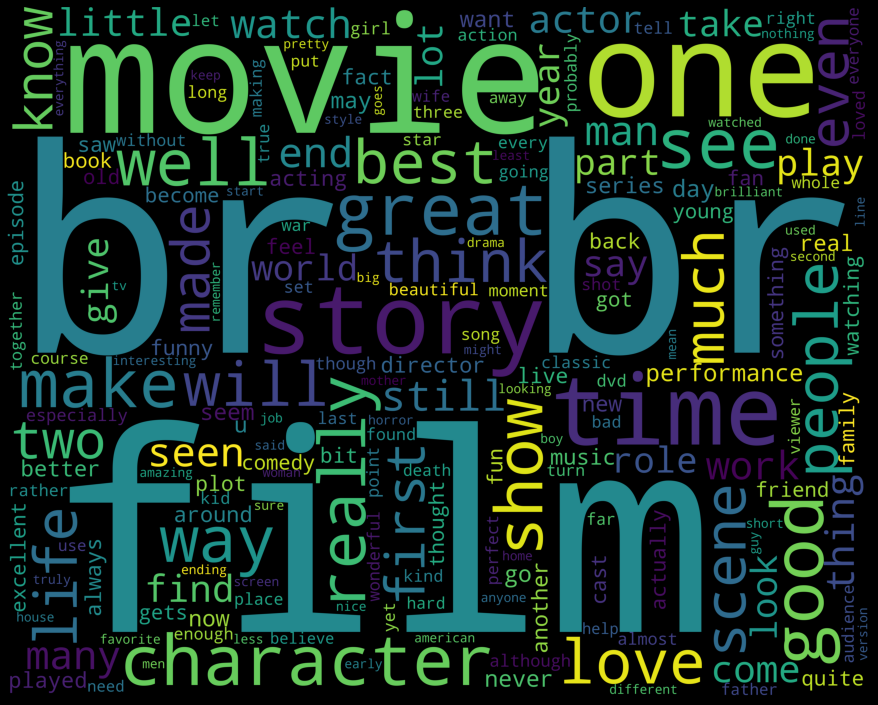

In [84]:
text = df1_pos.Review.values

Plot_world(text)

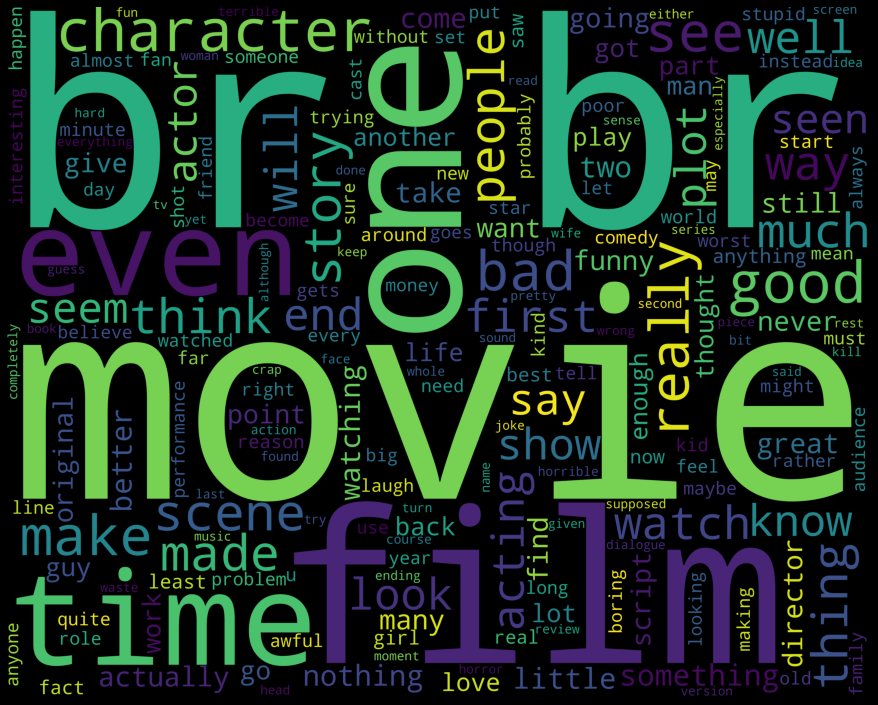

In [85]:
text = df1_neg.Review.values

Plot_world(text)

# single Predictions

In [86]:
def predict_single_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [87]:
index = 22
index_text = df['review'][index] 
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_single_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

What an absolutely stunning movie, if you have 2.5 hrs to kill, watch it, you won't regret it, it's too much fun! Rajnikanth carries the movie on his shoulders and although there isn't anything more other than him, I still liked it. The music by A.R.Rehman takes time to grow on you but after you heard it a few times, you really start liking it.
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9745742678642273


In [88]:
index = 42
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_single_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Of all the films I have seen, this one, The Rage, has got to be one of the worst yet. The direction, LOGIC, continuity, changes in plot-script and dialog made me cry out in pain. "How could ANYONE come up with something so crappy"? Gary Busey is know for his "B" movies, but this is a sure "W" movie. (W=waste).<br /><br />Take for example: about two dozen FBI & local law officers surround a trailer house with a jeep wagoneer. Inside the jeep is MA and is "confused" as to why all the cops are about. Within seconds a huge gun battle ensues, MA being killed straight off. The cops blast away at the jeep with gary and company blasting away at them. The cops fall like dominoes and the jeep with Gary drives around in circles and are not hit by one single bullet/pellet. MA is killed and gary seems to not to have noticed-damn that guy is tough. Truly a miracle, not since the six-shooter held 300 bullets has there been such a miracle.
Actual sentiment is  : negative
predicted sentiment is negativ

# CNN KERAS IMPLEMENTATION 

In [89]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [90]:
#truncate and pad input sequences
top_words = 5000
max_review_length = 500
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

In [91]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
#model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
train_history = model.fit(X_train, y_train, epochs=6, batch_size=256)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
157/157 [==============================] - 7s 35ms/step - loss: 0.5626 - accuracy: 0.6841
Epoch 2/6

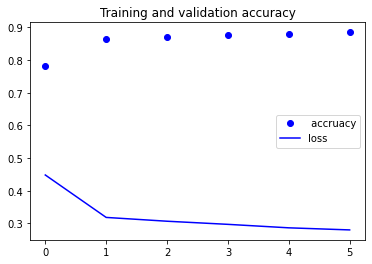

In [92]:
acc = train_history.history['accuracy']
loss = train_history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label=' accruacy')
plt.plot(epochs, loss, 'b', label='loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [93]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.20%


In [94]:
y_pred = model.predict(X_test)

y_pred = y_pred.argmax(axis=-1)
y_test = y_test.argmax(axis=-1)

# CNN Pytorch implementation 

In [95]:
import os
import sys
import random
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict
import re, string
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


!mkdir ./model_bakup/

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class CFG:
    batch_size = 20
    lr = 0.01
    eval_step_num = 300
    best_eval_acc = 0.0
    model_output_dir = './model_bakup/'
    seed = 2032
    
global_start_t = time.time()
print('ok')
#seed_everything(seed=42)

mkdir: cannot create directory ‘./model_bakup/’: File exists
ok


In [96]:
def pad(data_list, pad_length):
    padded_list = data_list.copy()
    
    if len(data_list) > pad_length:
        padded_list = data_list[-pad_length:]
        
    if len(data_list) < pad_length:
        padded_list = [1] * (pad_length-len(data_list)) + data_list
        
    return padded_list

def text_to_token(text):
    cleaned_text = clean_text(text)
    word_token_list = [word_id_dict.get(word, 0) for word in cleaned_text.split(' ')]
    pad_list = pad(word_token_list, MAX_LEN)
    token = ' '.join([str(x) for x in pad_list])
    return token
            
process_start_t = time.time()
print('start processing...')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df['review_tokens'] = df['review'].map(text_to_token)
print('ok, cost time: ', time.time()-process_start_t)
df.head(5)

start processing...
ok, cost time:  6.460301160812378


,review,sentiment,review_tokens
0,One of the other reviewers has mentioned that ...,1,2652 1384 21 0 533 34 4739 2513 5 2 1193 115 3...
1,A wonderful little production. <br /><br />The...,1,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
2,I thought this was a wonderful way to spend ti...,1,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
3,Basically there's a family where a little boy ...,0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,181 6 27 1025 170 49 287 661 3 988 80 6 84 8 2...


In [97]:
df_train = df.iloc[:15000]
df_valid = df.iloc[15000:20000]
df_test = df.iloc[20000:]
print(f'imdb_data_train.shape: {df_train.shape}, imdb_data_valid.shape: {df_valid.shape}, '
      f'imdb_data_test.shape: {df_test.shape}')

imdb_data_train.shape: (15000, 3), imdb_data_valid.shape: (5000, 3), imdb_data_test.shape: (30000, 3)


In [98]:
glove_path = '../input/glove6b/glove.6B.100d.txt'

cnt = 0
word_2_vector_map = {}
with open(glove_path) as fin:
    for line in fin:
        line = line.strip()
        word = line.split()[0]
        vector = np.array([float(val) for val in line.split()[1:]])
        word_2_vector_map[word] = vector
        cnt += 1
print('cnt is', cnt, 'len of word_2_vector_map: ', len(word_2_vector_map))

embed_size = 100
glove6b_100d_weight = torch.zeros(len(word_id_dict), embed_size)

for word, idx in word_id_dict.items():
    try:
        vector = word_2_vector_map[word]
    except:
        print('not found in : ', word)
        continue
    glove6b_100d_weight[idx, :] = torch.from_numpy(vector)
    
print('glove6b_100d_weight.shape: ', glove6b_100d_weight.shape)

cnt is 400000 len of word_2_vector_map:  400000
not found in :  
not found in :  
not found in :  youve
not found in :  werent
not found in :  shouldnt
not found in :  hadnt
not found in :  lowbudget
not found in :  theyve
not found in :  bmovie
not found in :  overthetop
not found in :  wouldve
not found in :  couldve
not found in :  writerdirector
not found in :  theyd
not found in :  oneliners
not found in :  reallife
not found in :  theyll
not found in :  mustsee
not found in :  itll
not found in :  everyones
not found in :  hitchcocks
not found in :  onedimensional
not found in :  madefortv
not found in :  wifes
not found in :  thoughtprovoking
not found in :  pg13
not found in :  familys
not found in :  middleaged
not found in :  anyones
not found in :  shouldve
not found in :  
not found in :  wellwritten
not found in :  bmovies
not found in :  wellmade
not found in :  welldone
not found in :  fastpaced
not found in :  wellacted
not found in :  drivein
not found in :  goodlook

In [99]:
cfg = CFG()
#seed_everything(seed=cfg.seed)

print('ok')

ok


In [100]:
class imdbDataset(Dataset):
    def __init__(self, data_df):
        self.data_df = data_df
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index]['sentiment']
        label = torch.tensor([float(label)], dtype=torch.float, device=device)
        
        tokens = self.data_df.iloc[index]['review_tokens']
        feature = torch.tensor([int(x) for x in tokens.split(' ')], dtype=torch.long, device=device)
            
        return feature, label
    
def generate_data_iter(cfg):
    global df_train, df_valid, df_test
    ds_train = imdbDataset(df_train)
    ds_valid = imdbDataset(df_valid)
    ds_test = imdbDataset(df_test)
    print('len of ds_train: ', len(ds_train), 'len of ds_valid: ', len(ds_valid),
          'len of ds_test: ', len(ds_test))

    dl_train = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
    dl_valid = DataLoader(ds_valid, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
    dl_test = DataLoader(ds_test, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
    return dl_train, dl_valid, dl_test

dl_train, dl_valid, dl_test = generate_data_iter(cfg)
print('ok')

len of ds_train:  15000 len of ds_valid:  5000 len of ds_test:  30000
ok


In [101]:
class CNN_Net(nn.Module):
    def __init__(self):
        global glove6b_100d_weight
        super().__init__()
        
        #self.embedding = nn.Embedding(num_embeddings=MAX_WORDS, embedding_dim=3, padding_idx=1)
        self.embedding = nn.Embedding.from_pretrained(glove6b_100d_weight, freeze=False)
        assert self.embedding.weight.requires_grad==True, 'should be True, because freeze=False'
        
        self.conv = nn.Sequential()
        self.conv.add_module('conv_1', nn.Conv1d(in_channels=100, out_channels=16, kernel_size=5))
        self.conv.add_module('pool_1', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_1', nn.ReLU())
        self.conv.add_module('conv_2', nn.Conv1d(in_channels=16, out_channels=128, kernel_size=2))
        self.conv.add_module('pool_2', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_2', nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module('flatten', nn.Flatten())
        self.dense.add_module('linear', nn.Linear(6144, 1))
        self.dense.add_module('sigmoid', nn.Sigmoid())
        
    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.conv(x)
        y = self.dense(x)
        return y
    
model = CNN_Net()
print(model)
model.to(device)     

print('ok')

CNN_Net(
  (embedding): Embedding(10000, 100)
  (conv): Sequential(
    (conv_1): Conv1d(100, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
ok


In [102]:
def accuracy(y_pred, y_true):
    if type(y_pred)==list:
        y_pred = np.array(y_pred)
    y_pred = (y_pred > 0.5)
    if type(y_true)==list:
        y_true = np.array(y_true)
    acc = (y_pred==y_true).mean()
    return acc

def evaluate(model, dl_test, device):
    global cfg
    model.eval()
    
    y_true_lst, y_pred_lst = [], []
    with torch.no_grad():
        for step, batch in tqdm(enumerate(dl_test)):
            feature, label = batch
            feature, label = feature.to(device), label.to(device)
            y_pred = model(feature)
            y_pred_lst += list(y_pred.detach().cpu().numpy())
            y_true_lst += list(label.detach().cpu().numpy())
            
    model.train() 
    acc = accuracy(y_pred_lst, y_true_lst)

    return acc
    
def train(model, dl_train, optimizer, loss_func, device):
    global cfg, global_step_num
    model.train()  
    
    y_true_lst, y_pred_lst = [], []
    #pbar = ProgressBar(n_total=len(dl_train), desc='Training')
    
    for step, batch in tqdm(enumerate(dl_train)):
        global_step_num += 1
        feature, label = batch
        feature, label = feature.to(device), label.to(device)
        #print('in train(), feature.shape:', feature.shape, 'label.shape: ', label.shape)
        y_pred = model(feature)
        train_loss = loss_func(y_pred, label)
        y_pred_lst += list(y_pred.detach().cpu().numpy())
        y_true_lst += list(label.detach().cpu().numpy())
        train_loss.backward()
        optimizer.step()
        model.zero_grad()
        
    print('in train(), len(dl_train): ', len(dl_train))
        
    acc = accuracy(y_pred_lst, y_true_lst)
    return acc

print('ok')

ok


In [103]:
global_best_train_acc, global_best_valid_acc = 0.0, 0.0
global_train_acc = 0.0
global_step_num = 0

epochs = 6
# optimizer=torch.optim.Adagrad(model.parameters(), lr=cfg.lr)
optimizer=torch.optim.Adam(model.parameters(), lr=cfg.lr)
loss_func = nn.BCELoss()

for epoch in range(epochs):
    train_acc = train(model, dl_train, optimizer, loss_func, device)
    valid_acc = evaluate(model, dl_valid, device)
    test_acc = evaluate(model, dl_test, device)
    print(f'in epoch: {epoch}, train_acc: {train_acc:.5f}, valid_acc: {valid_acc:.5f}, test_acc: {test_acc:.5f}')
    if train_acc > global_best_train_acc:
        global_best_train_acc = train_acc
    if valid_acc > global_best_valid_acc:
        global_best_valid_acc = valid_acc
        global_train_acc = train_acc
        print(f'get new best_valid_acc: {global_best_valid_acc:.5f}, save the model now!')
        torch.save(model.state_dict(), os.path.join(cfg.model_output_dir, 'best_step_model.pth'))

750it [00:11, 64.41it/s]
10it [00:00, 93.47it/s]

in train(), len(dl_train):  750


250it [00:02, 91.63it/s]
1500it [00:17, 86.47it/s]
7it [00:00, 66.92it/s]

in epoch: 0, train_acc: 0.75907, valid_acc: 0.79800, test_acc: 0.80150
get new best_valid_acc: 0.79800, save the model now!


750it [00:11, 64.68it/s]
10it [00:00, 94.10it/s]

in train(), len(dl_train):  750


250it [00:02, 92.06it/s]
1500it [00:17, 87.31it/s]
7it [00:00, 66.67it/s]

in epoch: 1, train_acc: 0.84887, valid_acc: 0.80780, test_acc: 0.80900
get new best_valid_acc: 0.80780, save the model now!


750it [00:11, 64.90it/s]
10it [00:00, 95.15it/s]

in train(), len(dl_train):  750


250it [00:02, 92.40it/s]
1500it [00:17, 87.43it/s]
7it [00:00, 65.99it/s]

in epoch: 2, train_acc: 0.89727, valid_acc: 0.80720, test_acc: 0.81070


750it [00:11, 64.92it/s]
10it [00:00, 93.38it/s]

in train(), len(dl_train):  750


250it [00:02, 92.70it/s]
1500it [00:16, 88.24it/s]
7it [00:00, 66.94it/s]

in epoch: 3, train_acc: 0.93287, valid_acc: 0.79700, test_acc: 0.80160


750it [00:11, 65.20it/s]
10it [00:00, 94.02it/s]

in train(), len(dl_train):  750


250it [00:02, 92.88it/s]
1500it [00:16, 88.37it/s]
7it [00:00, 58.95it/s]

in epoch: 4, train_acc: 0.95373, valid_acc: 0.78920, test_acc: 0.78957


750it [00:12, 62.22it/s]
10it [00:00, 93.03it/s]

in train(), len(dl_train):  750


250it [00:02, 92.52it/s]
1500it [00:16, 89.09it/s]

in epoch: 5, train_acc: 0.96293, valid_acc: 0.79500, test_acc: 0.79477


In [104]:
model = CNN_Net()
model.to(device)

model.load_state_dict(torch.load(os.path.join(cfg.model_output_dir, 'best_step_model.pth')))
test_acc = evaluate(model, dl_test, device)
print(f'final test_acc: {test_acc:.5f}, best_val_acc: {global_best_valid_acc:.5f}, '
      f'train_acc: {global_train_acc:.5f}, best_train_acc: {global_best_train_acc:.5f}')

print('total finished, cost time: ', time.time() - global_start_t)

1500it [00:16, 88.90it/s]

final test_acc: 0.80900, best_val_acc: 0.80780, train_acc: 0.84887, best_train_acc: 0.96293
total finished, cost time:  232.25909781455994
